# Machine Translation Project (PyTorch Framework)

## Introduction
In this notebook, the machine translation end2end pipeline is implemented; two DL models are implemented with **PyTorch** Frameworks; the goal is to translate from English to French

- **Preprocess Pipeline** - Convert text to sequence of integers.
- **Model 1** Bi-Directional RNN with (GRU/LSTM) cells; the neural network includes word embedding, encoder/decoder
- **Model 2** Implement Attention Model with Bi-Directional RNN cells 
- **Prediction** Run the model on English text.

In [1]:
%load_ext autoreload
%aimport helper, tests
%autoreload 1

In [2]:
import collections

import helper
import numpy as np
import project_tests as tests

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import logger
import time
import os
import copy

Using TensorFlow backend.


### Verify access to the GPU

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Dataset
We begin by investigating the dataset that will be used to train and evaluate your pipeline.  The most common datasets used for machine translation are from [WMT](http://www.statmt.org/).  
### Load Data
The data is located in `data/small_vocab_en` and `data/small_vocab_fr`. The `small_vocab_en` file contains English sentences with their French translations in the `small_vocab_fr` file. Load the English and French data from these files from running the cell below.

In [4]:
# Load English data
english_sentences = helper.load_data('data/small_vocab_en')
# Load French data
french_sentences = helper.load_data('data/small_vocab_fr')

print('Dataset Loaded')

Dataset Loaded


### Files
Each line in `small_vocab_en` contains an English sentence with the respective translation in each line of `small_vocab_fr`.  View the first two lines from each file.

In [5]:
for sample_i in range(2):
    print('small_vocab_en Line {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('small_vocab_fr Line {}:  {}'.format(sample_i + 1, french_sentences[sample_i]))

small_vocab_en Line 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
small_vocab_fr Line 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
small_vocab_en Line 2:  the united states is usually chilly during july , and it is usually freezing in november .
small_vocab_fr Line 2:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .


In [6]:
len(english_sentences), len(french_sentences)

(137861, 137861)

## Preprocess
Three steps in the text preprocess

- 1. **Vocabulary Creation**
- 2. **Tokenize** Implemented with Keras
- 3. **Padding to the same length** Implemented with Keras

The complexity of the problem is determined by the complexity of the vocabulary.  A more complex vocabulary is a more complex problem.  Let's look at the complexity of the dataset we'll be working with.

In [7]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


In [8]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    # TODO: Implement
    text_tokenizer = Tokenizer()
    text_tokenizer.fit_on_texts(x)
    text_tokenized = text_tokenizer.texts_to_sequences(x)
    
    return text_tokenized, text_tokenizer

tests.test_tokenize(tokenize)

# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


In [9]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    max_length = 0
    
    if length!=None:
        max_length = length
    else:
        for i in x:
            if len(i) > max_length:
                max_length = len(i)
                
    return pad_sequences(x, maxlen=max_length, padding='post')

tests.test_pad(pad)

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


In [10]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 344


## DataLoaders

To write the dataloaders format in Pytorch
- Split Dataset to Train and Validation and Test
- Applied into customized dataloaders

In [11]:
batch_size = 1024

In [12]:
def train_valid_split(x_data, y_data, split_ratio=0.2):
    
    assert(x_data.shape[0] == y_data.shape[0])
    data_length = x_data.shape[0]
    index = np.random.permutation(data_length).tolist()
    train_data_x = x_data[index[0:int(data_length*(1-split_ratio))], :]
    train_data_y = y_data[index[0:int(data_length*(1-split_ratio))], :]
    test_data_x = x_data[index[int(data_length*(1-split_ratio)):-1], :]
    test_data_y = y_data[index[int(data_length*(1-split_ratio)):-1], :]
    train_data = (train_data_x, train_data_y)
    test_data = (test_data_x, test_data_y)
    
    return train_data, test_data

In [13]:
class TimeSeriesDataset(Dataset):
    ### Sequence Dataset
    
    def __init__(self, sequences_in, sequences_out):
        super().__init__()
        self.len = sequences_in.shape[0]
        self.x_data = torch.from_numpy(sequences_in).long()
        self.y_data = torch.from_numpy(sequences_out).long()
    
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
        
    def __len__(self):
        return self.len
        

In [14]:
train_data, test_data = train_valid_split(preproc_english_sentences, preproc_french_sentences, split_ratio=0.2)

In [15]:
test = train_data[1].reshape(-1, 21)
test.shape

(110288, 21)

In [16]:
train_dataset = TimeSeriesDataset(train_data[0], train_data[1].reshape(-1, max_french_sequence_length))
test_dataset = TimeSeriesDataset(test_data[0], test_data[1].reshape(-1, max_french_sequence_length))
print(len(train_dataset))
print(len(test_dataset))

110288
27572


In [17]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
dataset_size = {'train':len(train_dataset), 'test':len(test_dataset)}
dataset_size

{'test': 27572, 'train': 110288}

In [19]:
dataloaders = dict()
dataloaders['train'] = train_loader
dataloaders['test'] = test_loader

## Models

- **Model 1** Bi-Directional RNN with (GRU/LSTM) cells; the neural network includes word embedding, encoder/decoder
- **Model 2** Implement Attention Model with Bi-Directional RNN cells 

After experimenting with the four simple architectures, you will construct a deeper architecture that is designed to outperform all four models.
### Ids Back to Text
The neural network will be translating the input to words ids, which isn't the final form we want.  We want the French translation.  The function `logits_to_text` will bridge the gab between the logits from the neural network to the French translation.  You'll be using this function to better understand the output of the neural network.


### Model 1


In [20]:
## Define help Model (Customized TimeDistributed Model)
class TimeDistributed(nn.Module):
    
    def __init__(self, module, batch_first=False):
        super().__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().reshape(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y

In [21]:
# Define Feedthrough Model
class Model1(nn.Module):
    
    def __init__(self, english_vocab_size, french_vocab_size, max_french_sequence_length, 
                 embedding_dim=200, hidden_dim=100, rnn_module = nn.LSTM):
        
        super().__init__()
        self.emb_vector = nn.Embedding(english_vocab_size+1
                                       , embedding_dim)
        self.enc_rnn_1 = rnn_module(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=1, 
                                    batch_first=True, bidirectional=True)
        self.dec_rnn_1 = rnn_module(input_size=2*hidden_dim, hidden_size=hidden_dim, num_layers=1, 
                                    batch_first=True, bidirectional=True)
        #self.bn = nn.BatchNorm1d(2*hidden_dim)
        self.fc = nn.Linear(2*hidden_dim, french_vocab_size+1)
        #self.time_series = TimeDistributed(self.fc, batch_first=True)
        
    def forward(self, inputs):
        
        embd_inputs = self.emb_vector(inputs)
        en_out, en_hn = self.enc_rnn_1(embd_inputs)
        en_out_end = en_out[:, -1]
        decode_inputs = en_out_end.view(en_out_end.size()[0], 1, -1)
        decode_inputs = decode_inputs.repeat(1, max_french_sequence_length, 1)
        de_out, dn_hn = self.dec_rnn_1(decode_inputs)
        # Add Batch Norm 
        bn_1 = nn.BatchNorm1d(de_out.shape[2]).to(device)
        b_de_out = bn_1(de_out.contiguous().view(de_out.shape[0], de_out.shape[2], de_out.shape[1])) 
        #shape=(batch, catogories, time-series-length)
        # softmax along the catogories axis
        outputs = self.fc(b_de_out.view(de_out.shape[0], de_out.shape[1], de_out.shape[2]))
        #outputs = F.softmax(self.fc(b_de_out.view(de_out.shape[0], de_out.shape[1], de_out.shape[2])), 
                            #dim=2) #shape=(batch, time-series-length, catogories)
        #outputs = F.softmax(self.time_series(b_de_out.contiguous().
        #                                    reshape(de_out.shape[0], de_out.shape[1], de_out.shape[2])), dim=2)
        #outputs = F.softmax(TimeDistributed(self.fc, batch_first=True)(de_out), dim=2)
        #outputs = torch.exp(outputs)
        
        return outputs.view(-1, outputs.shape[2], outputs.shape[1]) #shape=(batch, catogories, time-series-length)


### Model 2


In [22]:
## Define help Model (Customized TimeDistributed Model)
class TimeDistributed(nn.Module):
    
    def __init__(self, module, batch_first=False):
        super().__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y

In [23]:
## Define Scoring Function
def score_multiply(hx, enc_h):
    score = F.softmax(torch.matmul(enc_h, 
                                   hx.view(hx.shape[0], hx.shape[1], 1)),
                      dim=1)
    batch = score.shape[0]
    seq_length = score.shape[1]
    enc_h_new = torch.mul(enc_h, score)
    atten_vec = torch.sum(enc_h_new, dim=1)
    
    return atten_vec

## Define Attention_Decoder_Model
class Attention_Decode(nn.Module):
    
    def __init__(self, enc_h, input_dim, hidden_dim, rnn_module=nn.LSTMCell):
        
        # enc_h is encoded hidden tensor 
        super().__init__()
        self.input_dim = input_dim
        self.enc_h = enc_h
        self.dec_rnn = rnn_module(input_dim, hidden_dim)
    
    def forward(self, ini_x, ini_hc):
        
        # ini_x is the tensor for the initial input 
        # ini_hc is the tensor for the initial hidden layer; LSTMcell will be h and c states
        # hx, cx = LSTMcell(ini_x, ini_hc)
        # atten_vec = score(hx, enc_h) 
        # Glued atten_vec to hx => cat(atten_vec, hx)
        # x_next = tanh(wc[Glued_vector])
        # hc_next = (hx, cx)
        # foward (x_next, h_next) to create the next layer (repeat length times)
        
        hx, cx = self.dec_rnn(ini_x, (ini_hc[0], ini_hc[1]))
        atten_vec = score_multiply(hx, self.enc_h)
        glued_vector = torch.cat((atten_vec, hx), dim=1)
        x_next = F.tanh(nn.Linear(glued_vector.shape[1], self.input_dim)(glued_vector))
        hc_next = (hx, cx)
  
        return x_next, hc_next

In [24]:
# Define Feedthrough Model
class Model2(nn.Module):
    
    def __init__(self, english_vocab_size, french_vocab_size, max_french_sequence_length, 
                 embedding_dim=200, hidden_dim=100, rnn_encode_module=nn.LSTM, rnn_decode_cell=nn.LSTMCell):
        
        super().__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.emb_vector = nn.Embedding(english_vocab_size+1, embedding_dim)
        self.enc_rnn_1 = rnn_encode_module(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=1, 
                                    batch_first=True, bidirectional=True)
        self.rnn_decode_cell = rnn_decode_cell
        self.fc = nn.Linear(embedding_dim, french_vocab_size+1)
        #self.time_series = TimeDistributed(self.fc, batch_first=True)
        
    def forward(self, inputs):
        
        embd_inputs = self.emb_vector(inputs)
        en_out, en_hn = self.enc_rnn_1(embd_inputs)
        enc_h = en_out # Treat the output as the hidden state
        #Initiate Attention Decode Module        
        Decode_process = nn.ModuleList([Attention_Decode(enc_h, input_dim=self.embedding_dim, hidden_dim=self.hidden_dim*2, 
                                                         rnn_module=nn.LSTMCell).to(device) 
                                        for i in range(max_french_sequence_length)])
        # 1st x_next and h_next
        # x_next is <END>
        # hc_next is zero tensor with the correct dimension 
        h_0 = torch.zeros((inputs.shape[0], self.hidden_dim*2))
        c_0 = torch.zeros((inputs.shape[0], self.hidden_dim*2))
        # i_0 should implement with the <END> embed matrix (batch, embd_dim)
        i_0 = self.emb_vector(torch.zeros((inputs.shape[0])).type(torch.LongTensor))
        x_next = i_0
        hc_next = (h_0, c_0)
        x_sequence = list()
        hc_sequence = list() # h contains (h, c)
        
        for i, decode in enumerate(Decode_process):
            x_next, hc_next = decode(x_next, hc_next)
            x_sequence.append(x_next)
            hc_sequence.append(hc_next)
        
        # stack x_sequence and hc_sequence
        x_sequence = [i.view(i.shape[0], 1, -1) for i in x_sequence]
        outputs_c = torch.cat(x_sequence, dim=1)
        # BatchNorm
        bn_1 = nn.BatchNorm1d(outputs_c.shape[2]).to(device)
        outputs_c_bn = bn_1(outputs_c.contiguous().view(outputs_c.shape[0], outputs_c.shape[2], outputs_c.shape[1])) 
        # softmax along the final matrix
        #
        outputs = F.softmax(self.fc(outputs_c_bn.view
                                    (outputs_c.shape[0], outputs_c.shape[1], outputs_c.shape[2])), dim=2)    
        #outputs = F.softmax(self.time_series(outputs_c_bn.view
                                             #(outputs_c.shape[0], outputs_c.shape[1], outputs_c.shape[2])), dim=2)
        
        return outputs.view(-1, outputs.shape[2], outputs.shape[1])



## Loss/Accuracy and Optimization/LRrate Function Setting


In [145]:
model = Model1(english_vocab_size, french_vocab_size, max_french_sequence_length, 
                 embedding_dim=200, hidden_dim=100, rnn_module = nn.LSTM)

In [146]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()

### Learning_Rate Finder

In [62]:
def mac_lr_finder(model, criterion, lr_logrange=[-5, 0]):
    
    # numbers of iterations
    n_iter = len(list(dataloaders['train'])) #108
    
    # lr rate matrix 
    lr_matrix = np.logspace(lr_logrange[0], lr_logrange[1], n_iter)
    loss_matrix = np.zeros(n_iter)
    
    for epoch in range(1):
        
        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode; won't alter to different dropout and BatchNorm weights

            idx = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Set Optimizer
                #optimizer = optim.SGD(model.parameters(), 
                 #                     lr=lr_matrix[idx], 
                  #                    momentum=1,
                   #                   nesterov=True)
                
                optimizer = optim.Adam(model.parameters(), 
                                       amsgrad=True)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # turn on the tracking history in train and turn off the tracking history in others
                with torch.set_grad_enabled(phase == 'train'): #set gradient calculation enabled
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss_matrix[idx] = loss.item()

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                idx = idx+1
                        
    lr_matrix = lr_matrix.reshape((lr_matrix.shape[0], 1))
    loss_matrix = loss_matrix.reshape((loss_matrix.shape[0], 1))

    return np.concatenate((lr_matrix, loss_matrix), axis=1)


In [63]:
lr_loss_matrix = mac_lr_finder(model=model, criterion=criterion, lr_logrange=[-5, 0])

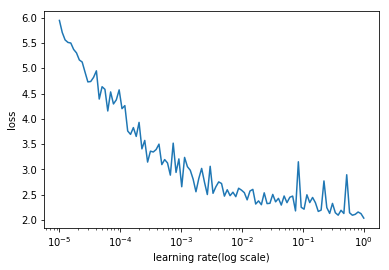

In [64]:
plt.plot(lr_loss_matrix[:, 0], lr_loss_matrix[:, 1])
plt.xlabel('learning rate(log scale)')
plt.ylabel('loss')
plt.xscale('log')
plt.show()

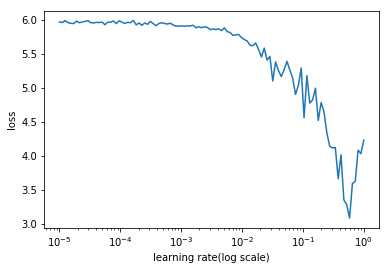

In [59]:
plt.plot(lr_loss_matrix[:, 0], lr_loss_matrix[:, 1])
plt.xlabel('learning rate(log scale)')
plt.ylabel('loss')
plt.xscale('log')
plt.show()

### Learning Rate Scheduler

In [147]:
model_adam = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(model.parameters(), lr=0.1, amsgrad=True)

In [148]:
model_sgd = model.to(device)
optimizer_sgd = optim.SGD(model.parameters(), lr=0.5, momentum=1, nesterov=True)

#exp_lr_scheduler_anneal = lr_scheduler.CosineAnnealingLR(optimizer=optimizer_sgd, 
#                                                         T_max=400, 
#                                                         eta_min=7.5e-3, 
#                                                         last_epoch=-1)

In [149]:
def lr_decay(epoch):
    lr_matrix = np.ones(1200)
    lr_matrix[0:300] = 0.1
    lr_matrix[300:600] = 5e-2
    lr_matrix[600:900] = 1e-2
    lr_matrix[900:] = 7.5e-3
    
    return lr_matrix[epoch]

def lr_decay_sgd(epoch):
    lr_matrix = np.ones(1200)
    lr_matrix[0:300] = 0.5
    lr_matrix[300:600] = 0.25
    lr_matrix[600:900] = 0.1
    lr_matrix[900:] = 0.05
    
    return lr_matrix[epoch]

exp_lr_scheduler = lr_scheduler.LambdaLR(optimizer=optimizer_adam, lr_lambda=lr_decay, last_epoch=-1)
exp_lr_scheduler_sgd = lr_scheduler.LambdaLR(optimizer=optimizer_sgd, lr_lambda=lr_decay_sgd, last_epoch=-1)

## Training & Validation Loop


Check Input and Output Tensor Shape

In [150]:
a = list(dataloaders['train'])
b = list(dataloaders['test'])
print(len(a), len(b))

108 27


In [151]:
input, label = a[0]

In [152]:
print(input[0].view(1,-1).shape)
print(label[0].view(1,-1).shape)

torch.Size([1, 15])
torch.Size([1, 21])


In [155]:
output = model_adam(input.to(device))

In [154]:
output.shape

torch.Size([1024, 345, 21])

### define training procedure

In [79]:
def mac_train_model(model, criterion, optimizer, scheduler, num_epochs=18):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 24)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode; won't alter to different dropout and BatchNorm weights

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # turn on the tracking history in train and turn off the tracking history in others
                with torch.set_grad_enabled(phase == 'train'): #set gradient calculation enabled
                    outputs = model(inputs)
                    max_tensor, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.shape[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_size[phase]
            epoch_acc = running_corrects.double()*100 / (dataset_size[phase]*max_french_sequence_length)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


## Train


In [156]:
model_adam = mac_train_model(model=model_adam, criterion=criterion, optimizer=optimizer_adam, 
                          scheduler=exp_lr_scheduler, num_epochs=1200)
torch.save(model_adam, './data/model_adam.pt')

Epoch 0/1199
------------------------
train Loss: 2.2288 Acc: 53.8899
test Loss: 1.5999 Acc: 62.0377

Epoch 1/1199
------------------------
train Loss: 1.4043 Acc: 65.2022
test Loss: 1.2285 Acc: 68.5834

Epoch 2/1199
------------------------
train Loss: 1.1070 Acc: 71.2066
test Loss: 0.9986 Acc: 73.5731

Epoch 3/1199
------------------------
train Loss: 0.9117 Acc: 75.5856
test Loss: 0.8345 Acc: 77.4329

Epoch 4/1199
------------------------
train Loss: 0.7801 Acc: 78.7010
test Loss: 0.7332 Acc: 80.0142

Epoch 5/1199
------------------------
train Loss: 0.6824 Acc: 81.2853
test Loss: 0.6331 Acc: 82.4719

Epoch 6/1199
------------------------
train Loss: 0.5997 Acc: 83.5274
test Loss: 0.5824 Acc: 84.0138

Epoch 7/1199
------------------------
train Loss: 0.5445 Acc: 85.0181
test Loss: 0.5300 Acc: 85.4801

Epoch 8/1199
------------------------
train Loss: 0.4876 Acc: 86.5498
test Loss: 0.4919 Acc: 86.6063

Epoch 9/1199
------------------------
train Loss: 0.4519 Acc: 87.6395
test Loss: 0

test Loss: 0.2224 Acc: 94.2188

Epoch 80/1199
------------------------
train Loss: 0.1732 Acc: 95.2621
test Loss: 0.2063 Acc: 94.6711

Epoch 81/1199
------------------------
train Loss: 0.1577 Acc: 95.6544
test Loss: 0.1884 Acc: 95.0564

Epoch 82/1199
------------------------
train Loss: 0.1995 Acc: 94.4981
test Loss: 0.2212 Acc: 94.1025

Epoch 83/1199
------------------------
train Loss: 0.1722 Acc: 95.2346
test Loss: 0.1883 Acc: 95.0488

Epoch 84/1199
------------------------
train Loss: 0.1827 Acc: 95.0056
test Loss: 0.2180 Acc: 94.2647

Epoch 85/1199
------------------------
train Loss: 0.1627 Acc: 95.5013
test Loss: 0.1936 Acc: 94.9452

Epoch 86/1199
------------------------
train Loss: 0.1478 Acc: 95.9031
test Loss: 0.1910 Acc: 95.0036

Epoch 87/1199
------------------------
train Loss: 0.1454 Acc: 95.9846
test Loss: 0.1761 Acc: 95.5143

Epoch 88/1199
------------------------
train Loss: 0.1527 Acc: 95.7937
test Loss: 0.2209 Acc: 94.2005

Epoch 89/1199
------------------------
tr

test Loss: 0.1557 Acc: 96.0750

Epoch 159/1199
------------------------
train Loss: 0.1089 Acc: 96.9663
test Loss: 0.1604 Acc: 95.9895

Epoch 160/1199
------------------------
train Loss: 0.1054 Acc: 97.0767
test Loss: 0.1564 Acc: 96.0797

Epoch 161/1199
------------------------
train Loss: 0.1029 Acc: 97.1250
test Loss: 0.1562 Acc: 96.1553

Epoch 162/1199
------------------------
train Loss: 0.1056 Acc: 97.0820
test Loss: 0.1694 Acc: 95.7092

Epoch 163/1199
------------------------
train Loss: 0.1206 Acc: 96.7054
test Loss: 0.1631 Acc: 95.8887

Epoch 164/1199
------------------------
train Loss: 0.1081 Acc: 97.0036
test Loss: 0.1589 Acc: 96.0080

Epoch 165/1199
------------------------
train Loss: 0.1064 Acc: 97.0432
test Loss: 0.1555 Acc: 96.1130

Epoch 166/1199
------------------------
train Loss: 0.1063 Acc: 97.0617
test Loss: 0.1648 Acc: 95.8650

Epoch 167/1199
------------------------
train Loss: 0.1041 Acc: 97.1084
test Loss: 0.1567 Acc: 96.1099

Epoch 168/1199
-----------------

test Loss: 0.1851 Acc: 95.1455

Epoch 238/1199
------------------------
train Loss: 0.1414 Acc: 96.0250
test Loss: 0.1858 Acc: 95.0989

Epoch 239/1199
------------------------
train Loss: 0.1402 Acc: 96.0813
test Loss: 0.1875 Acc: 95.1329

Epoch 240/1199
------------------------
train Loss: 0.1431 Acc: 96.0211
test Loss: 0.1845 Acc: 95.1744

Epoch 241/1199
------------------------
train Loss: 0.1450 Acc: 95.9612
test Loss: 0.2056 Acc: 94.6383

Epoch 242/1199
------------------------
train Loss: 0.1529 Acc: 95.7639
test Loss: 0.1877 Acc: 95.1473

Epoch 243/1199
------------------------
train Loss: 0.1487 Acc: 95.8623
test Loss: 0.1869 Acc: 95.1700

Epoch 244/1199
------------------------
train Loss: 0.1399 Acc: 96.0857
test Loss: 0.1965 Acc: 94.8820

Epoch 245/1199
------------------------
train Loss: 0.1345 Acc: 96.2055
test Loss: 0.1909 Acc: 95.0692

Epoch 246/1199
------------------------
train Loss: 0.1377 Acc: 96.1830
test Loss: 0.1923 Acc: 95.0498

Epoch 247/1199
-----------------

test Loss: 0.1657 Acc: 95.7168

Epoch 317/1199
------------------------
train Loss: 0.1116 Acc: 96.8781
test Loss: 0.1629 Acc: 95.8284

Epoch 318/1199
------------------------
train Loss: 0.1080 Acc: 96.9874
test Loss: 0.1673 Acc: 95.7464

Epoch 319/1199
------------------------
train Loss: 0.1042 Acc: 97.1067
test Loss: 0.1599 Acc: 95.9474

Epoch 320/1199
------------------------
train Loss: 0.1016 Acc: 97.1911
test Loss: 0.1605 Acc: 95.9573

Epoch 321/1199
------------------------
train Loss: 0.0986 Acc: 97.2766
test Loss: 0.1555 Acc: 96.0683

Epoch 322/1199
------------------------
train Loss: 0.0970 Acc: 97.3197
test Loss: 0.1540 Acc: 96.1491

Epoch 323/1199
------------------------
train Loss: 0.0948 Acc: 97.3876
test Loss: 0.1614 Acc: 96.0686

Epoch 324/1199
------------------------
train Loss: 0.1050 Acc: 97.1126
test Loss: 0.1587 Acc: 96.0809

Epoch 325/1199
------------------------
train Loss: 0.0979 Acc: 97.2885
test Loss: 0.1566 Acc: 96.0562

Epoch 326/1199
-----------------

test Loss: 0.1537 Acc: 96.3113

Epoch 396/1199
------------------------
train Loss: 0.0763 Acc: 97.8894
test Loss: 0.1612 Acc: 96.1429

Epoch 397/1199
------------------------
train Loss: 0.0899 Acc: 97.5403
test Loss: 0.1568 Acc: 96.3215

Epoch 398/1199
------------------------
train Loss: 0.0808 Acc: 97.7415
test Loss: 0.1497 Acc: 96.3970

Epoch 399/1199
------------------------
train Loss: 0.0826 Acc: 97.6949
test Loss: 0.1554 Acc: 96.3308

Epoch 400/1199
------------------------
train Loss: 0.0824 Acc: 97.7260
test Loss: 0.1703 Acc: 96.1035

Epoch 401/1199
------------------------
train Loss: 0.0935 Acc: 97.4456
test Loss: 0.1639 Acc: 96.0996

Epoch 402/1199
------------------------
train Loss: 0.1013 Acc: 97.2539
test Loss: 0.1607 Acc: 96.1545

Epoch 403/1199
------------------------
train Loss: 0.0971 Acc: 97.3232
test Loss: 0.1618 Acc: 96.0220

Epoch 404/1199
------------------------
train Loss: 0.0894 Acc: 97.4869
test Loss: 0.1546 Acc: 96.1961

Epoch 405/1199
-----------------

test Loss: 0.1547 Acc: 96.4099

Epoch 475/1199
------------------------
train Loss: 0.0737 Acc: 97.9437
test Loss: 0.1580 Acc: 96.2830

Epoch 476/1199
------------------------
train Loss: 0.0892 Acc: 97.4652
test Loss: 0.1766 Acc: 96.0013

Epoch 477/1199
------------------------
train Loss: 0.0960 Acc: 97.3552
test Loss: 0.1629 Acc: 96.2053

Epoch 478/1199
------------------------
train Loss: 0.0978 Acc: 97.3267
test Loss: 0.1678 Acc: 96.0666

Epoch 479/1199
------------------------
train Loss: 0.0949 Acc: 97.4219
test Loss: 0.1713 Acc: 96.0647

Epoch 480/1199
------------------------
train Loss: 0.0893 Acc: 97.5121
test Loss: 0.1575 Acc: 96.3424

Epoch 481/1199
------------------------
train Loss: 0.1027 Acc: 97.1422
test Loss: 0.1635 Acc: 96.0844

Epoch 482/1199
------------------------
train Loss: 0.0911 Acc: 97.4619
test Loss: 0.1612 Acc: 96.1811

Epoch 483/1199
------------------------
train Loss: 0.0818 Acc: 97.7032
test Loss: 0.1579 Acc: 96.2690

Epoch 484/1199
-----------------

test Loss: 0.1538 Acc: 96.4809

Epoch 554/1199
------------------------
train Loss: 0.0731 Acc: 97.9270
test Loss: 0.1521 Acc: 96.5386

Epoch 555/1199
------------------------
train Loss: 0.0761 Acc: 97.8582
test Loss: 0.1495 Acc: 96.5350

Epoch 556/1199
------------------------
train Loss: 0.0739 Acc: 97.9602
test Loss: 0.1629 Acc: 96.3662

Epoch 557/1199
------------------------
train Loss: 0.1032 Acc: 97.2984
test Loss: 0.1765 Acc: 95.9702

Epoch 558/1199
------------------------
train Loss: 0.1295 Acc: 96.7234
test Loss: 0.1978 Acc: 95.5130

Epoch 559/1199
------------------------
train Loss: 0.1165 Acc: 96.9194
test Loss: 0.1706 Acc: 96.0816

Epoch 560/1199
------------------------
train Loss: 0.0959 Acc: 97.3754
test Loss: 0.1651 Acc: 96.2030

Epoch 561/1199
------------------------
train Loss: 0.0903 Acc: 97.5276
test Loss: 0.1650 Acc: 96.2165

Epoch 562/1199
------------------------
train Loss: 0.1302 Acc: 96.5905
test Loss: 0.1908 Acc: 95.5699

Epoch 563/1199
-----------------

test Loss: 0.1464 Acc: 96.6954

Epoch 633/1199
------------------------
train Loss: 0.0636 Acc: 98.2399
test Loss: 0.1460 Acc: 96.6971

Epoch 634/1199
------------------------
train Loss: 0.0608 Acc: 98.3262
test Loss: 0.1447 Acc: 96.7329

Epoch 635/1199
------------------------
train Loss: 0.0639 Acc: 98.2408
test Loss: 0.1508 Acc: 96.5481

Epoch 636/1199
------------------------
train Loss: 0.0622 Acc: 98.2920
test Loss: 0.1479 Acc: 96.6438

Epoch 637/1199
------------------------
train Loss: 0.0617 Acc: 98.2914
test Loss: 0.1458 Acc: 96.7032

Epoch 638/1199
------------------------
train Loss: 0.0632 Acc: 98.2574
test Loss: 0.1440 Acc: 96.7381

Epoch 639/1199
------------------------
train Loss: 0.0639 Acc: 98.2340
test Loss: 0.1452 Acc: 96.7861

Epoch 640/1199
------------------------
train Loss: 0.0630 Acc: 98.2674
test Loss: 0.1442 Acc: 96.7859

Epoch 641/1199
------------------------
train Loss: 0.0621 Acc: 98.3014
test Loss: 0.1456 Acc: 96.7483

Epoch 642/1199
-----------------

test Loss: 0.1479 Acc: 96.7502

Epoch 712/1199
------------------------
train Loss: 0.0565 Acc: 98.4388
test Loss: 0.1458 Acc: 96.8303

Epoch 713/1199
------------------------
train Loss: 0.0553 Acc: 98.4760
test Loss: 0.1491 Acc: 96.7574

Epoch 714/1199
------------------------
train Loss: 0.0547 Acc: 98.4924
test Loss: 0.1484 Acc: 96.7935

Epoch 715/1199
------------------------
train Loss: 0.0564 Acc: 98.4455
test Loss: 0.1437 Acc: 96.8954

Epoch 716/1199
------------------------
train Loss: 0.0555 Acc: 98.4745
test Loss: 0.1445 Acc: 96.8873

Epoch 717/1199
------------------------
train Loss: 0.0563 Acc: 98.4437
test Loss: 0.1514 Acc: 96.7426

Epoch 718/1199
------------------------
train Loss: 0.0556 Acc: 98.4661
test Loss: 0.1493 Acc: 96.8265

Epoch 719/1199
------------------------
train Loss: 0.0532 Acc: 98.5431
test Loss: 0.1450 Acc: 96.8631

Epoch 720/1199
------------------------
train Loss: 0.0549 Acc: 98.4965
test Loss: 0.1490 Acc: 96.7666

Epoch 721/1199
-----------------

test Loss: 0.1506 Acc: 96.8830

Epoch 791/1199
------------------------
train Loss: 0.0546 Acc: 98.4869
test Loss: 0.1502 Acc: 96.8287

Epoch 792/1199
------------------------
train Loss: 0.0553 Acc: 98.4698
test Loss: 0.1474 Acc: 96.8294

Epoch 793/1199
------------------------
train Loss: 0.0523 Acc: 98.5412
test Loss: 0.1485 Acc: 96.7400

Epoch 794/1199
------------------------
train Loss: 0.0518 Acc: 98.5740
test Loss: 0.1508 Acc: 96.8241

Epoch 795/1199
------------------------
train Loss: 0.0525 Acc: 98.5524
test Loss: 0.1481 Acc: 96.8619

Epoch 796/1199
------------------------
train Loss: 0.0513 Acc: 98.5803
test Loss: 0.1480 Acc: 96.7952

Epoch 797/1199
------------------------
train Loss: 0.0494 Acc: 98.6352
test Loss: 0.1457 Acc: 96.9073

Epoch 798/1199
------------------------
train Loss: 0.0519 Acc: 98.5477
test Loss: 0.1474 Acc: 96.8420

Epoch 799/1199
------------------------
train Loss: 0.0529 Acc: 98.5461
test Loss: 0.1512 Acc: 96.7470

Epoch 800/1199
-----------------

test Loss: 0.1526 Acc: 96.8246

Epoch 870/1199
------------------------
train Loss: 0.0492 Acc: 98.6402
test Loss: 0.1544 Acc: 96.8192

Epoch 871/1199
------------------------
train Loss: 0.0514 Acc: 98.5868
test Loss: 0.1485 Acc: 96.9128

Epoch 872/1199
------------------------
train Loss: 0.0492 Acc: 98.6415
test Loss: 0.1479 Acc: 97.0090

Epoch 873/1199
------------------------
train Loss: 0.0510 Acc: 98.5899
test Loss: 0.1515 Acc: 96.8629

Epoch 874/1199
------------------------
train Loss: 0.0492 Acc: 98.6278
test Loss: 0.1489 Acc: 96.8268

Epoch 875/1199
------------------------
train Loss: 0.0504 Acc: 98.6236
test Loss: 0.1490 Acc: 96.8975

Epoch 876/1199
------------------------
train Loss: 0.0487 Acc: 98.6477
test Loss: 0.1491 Acc: 96.8814

Epoch 877/1199
------------------------
train Loss: 0.0495 Acc: 98.6252
test Loss: 0.1510 Acc: 96.8334

Epoch 878/1199
------------------------
train Loss: 0.0499 Acc: 98.6230
test Loss: 0.1521 Acc: 96.9211

Epoch 879/1199
-----------------

test Loss: 0.1490 Acc: 96.8802

Epoch 949/1199
------------------------
train Loss: 0.0484 Acc: 98.6690
test Loss: 0.1516 Acc: 96.8168

Epoch 950/1199
------------------------
train Loss: 0.0495 Acc: 98.6510
test Loss: 0.1486 Acc: 96.9355

Epoch 951/1199
------------------------
train Loss: 0.0498 Acc: 98.6339
test Loss: 0.1495 Acc: 96.8745

Epoch 952/1199
------------------------
train Loss: 0.0471 Acc: 98.6922
test Loss: 0.1550 Acc: 96.7985

Epoch 953/1199
------------------------
train Loss: 0.0485 Acc: 98.6626
test Loss: 0.1504 Acc: 96.8900

Epoch 954/1199
------------------------
train Loss: 0.0491 Acc: 98.6461
test Loss: 0.1520 Acc: 96.8997

Epoch 955/1199
------------------------
train Loss: 0.0478 Acc: 98.6876
test Loss: 0.1496 Acc: 96.9123

Epoch 956/1199
------------------------
train Loss: 0.0477 Acc: 98.6845
test Loss: 0.1486 Acc: 96.9873

Epoch 957/1199
------------------------
train Loss: 0.0465 Acc: 98.7130
test Loss: 0.1520 Acc: 96.8434

Epoch 958/1199
-----------------

train Loss: 0.0477 Acc: 98.6758
test Loss: 0.1527 Acc: 96.9740

Epoch 1028/1199
------------------------
train Loss: 0.0482 Acc: 98.6774
test Loss: 0.1511 Acc: 96.9424

Epoch 1029/1199
------------------------
train Loss: 0.0460 Acc: 98.7194
test Loss: 0.1536 Acc: 96.8213

Epoch 1030/1199
------------------------
train Loss: 0.0487 Acc: 98.6458
test Loss: 0.1561 Acc: 96.8180

Epoch 1031/1199
------------------------
train Loss: 0.0443 Acc: 98.7679
test Loss: 0.1557 Acc: 96.9436

Epoch 1032/1199
------------------------
train Loss: 0.0460 Acc: 98.7253
test Loss: 0.1495 Acc: 96.9795

Epoch 1033/1199
------------------------
train Loss: 0.0465 Acc: 98.7233
test Loss: 0.1499 Acc: 96.9605

Epoch 1034/1199
------------------------
train Loss: 0.0459 Acc: 98.7331
test Loss: 0.1540 Acc: 96.8826

Epoch 1035/1199
------------------------
train Loss: 0.0443 Acc: 98.7759
test Loss: 0.1479 Acc: 96.9412

Epoch 1036/1199
------------------------
train Loss: 0.0502 Acc: 98.6211
test Loss: 0.1515 Acc: 

test Loss: 0.1504 Acc: 96.9887

Epoch 1106/1199
------------------------
train Loss: 0.0458 Acc: 98.7198
test Loss: 0.1525 Acc: 96.8600

Epoch 1107/1199
------------------------
train Loss: 0.0442 Acc: 98.7663
test Loss: 0.1552 Acc: 96.9289

Epoch 1108/1199
------------------------
train Loss: 0.0456 Acc: 98.7333
test Loss: 0.1530 Acc: 96.9581

Epoch 1109/1199
------------------------
train Loss: 0.0465 Acc: 98.7142
test Loss: 0.1578 Acc: 96.7593

Epoch 1110/1199
------------------------
train Loss: 0.0458 Acc: 98.7320
test Loss: 0.1559 Acc: 96.9113

Epoch 1111/1199
------------------------
train Loss: 0.0472 Acc: 98.6883
test Loss: 0.1532 Acc: 96.8576

Epoch 1112/1199
------------------------
train Loss: 0.0442 Acc: 98.7715
test Loss: 0.1477 Acc: 97.0527

Epoch 1113/1199
------------------------
train Loss: 0.0455 Acc: 98.7314
test Loss: 0.1520 Acc: 96.9964

Epoch 1114/1199
------------------------
train Loss: 0.0462 Acc: 98.6980
test Loss: 0.1546 Acc: 96.9092

Epoch 1115/1199
-------

train Loss: 0.0460 Acc: 98.7084
test Loss: 0.1513 Acc: 97.0391

Epoch 1185/1199
------------------------
train Loss: 0.0446 Acc: 98.7632
test Loss: 0.1525 Acc: 96.9683

Epoch 1186/1199
------------------------
train Loss: 0.0439 Acc: 98.7855
test Loss: 0.1559 Acc: 96.8790

Epoch 1187/1199
------------------------
train Loss: 0.0465 Acc: 98.7156
test Loss: 0.1553 Acc: 96.9462

Epoch 1188/1199
------------------------
train Loss: 0.0457 Acc: 98.7263
test Loss: 0.1528 Acc: 96.9662

Epoch 1189/1199
------------------------
train Loss: 0.0460 Acc: 98.7246
test Loss: 0.1532 Acc: 97.0215

Epoch 1190/1199
------------------------
train Loss: 0.0442 Acc: 98.7733
test Loss: 0.1499 Acc: 96.9350

Epoch 1191/1199
------------------------
train Loss: 0.0441 Acc: 98.7671
test Loss: 0.1540 Acc: 96.9804

Epoch 1192/1199
------------------------
train Loss: 0.0473 Acc: 98.6799
test Loss: 0.1532 Acc: 97.0270

Epoch 1193/1199
------------------------
train Loss: 0.0451 Acc: 98.7467
test Loss: 0.1552 Acc: 

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Model1. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [157]:
model_sgd = mac_train_model(model=model_sgd, criterion=criterion, optimizer=optimizer_sgd, 
                          scheduler=exp_lr_scheduler_sgd, num_epochs=1200)
torch.save(model_sgd, './data/model_sgd.pt')

Epoch 0/1199
------------------------
train Loss: 0.2521 Acc: 94.7714
test Loss: 1.1996 Acc: 79.4876

Epoch 1/1199
------------------------
train Loss: 2.0123 Acc: 67.5005
test Loss: 2.7442 Acc: 59.1124

Epoch 2/1199
------------------------
train Loss: 2.6890 Acc: 58.2699
test Loss: 3.1334 Acc: 53.7248

Epoch 3/1199
------------------------
train Loss: 5.9153 Acc: 44.1509
test Loss: 7.3086 Acc: 38.4014

Epoch 4/1199
------------------------
train Loss: 7.0583 Acc: 41.8272
test Loss: 7.3894 Acc: 38.8101

Epoch 5/1199
------------------------
train Loss: 8.5165 Acc: 41.2317
test Loss: 9.8028 Acc: 41.1758

Epoch 6/1199
------------------------
train Loss: 10.4037 Acc: 41.9070
test Loss: 11.2110 Acc: 43.0456

Epoch 7/1199
------------------------
train Loss: 12.4096 Acc: 42.9188
test Loss: 13.9722 Acc: 42.1404

Epoch 8/1199
------------------------
train Loss: 16.8186 Acc: 42.3044
test Loss: 22.4195 Acc: 39.4660

Epoch 9/1199
------------------------
train Loss: 24.8638 Acc: 37.8142
test 

train Loss: 223.2785 Acc: 44.8679
test Loss: 229.3112 Acc: 43.3112

Epoch 78/1199
------------------------
train Loss: 228.1385 Acc: 42.9894
test Loss: 223.7037 Acc: 43.9108

Epoch 79/1199
------------------------
train Loss: 225.6572 Acc: 44.0784
test Loss: 223.7259 Acc: 42.9941

Epoch 80/1199
------------------------
train Loss: 231.6492 Acc: 43.7459
test Loss: 230.1796 Acc: 44.8530

Epoch 81/1199
------------------------
train Loss: 233.5015 Acc: 44.4937
test Loss: 228.6742 Acc: 43.2855

Epoch 82/1199
------------------------
train Loss: 235.9046 Acc: 42.4311
test Loss: 233.3223 Acc: 42.6071

Epoch 83/1199
------------------------
train Loss: 241.3952 Acc: 43.6112
test Loss: 255.6742 Acc: 43.8400

Epoch 84/1199
------------------------
train Loss: 249.5699 Acc: 44.1031
test Loss: 251.2138 Acc: 43.0853

Epoch 85/1199
------------------------
train Loss: 255.1396 Acc: 43.0662
test Loss: 257.6467 Acc: 43.4212

Epoch 86/1199
------------------------
train Loss: 254.5213 Acc: 44.0106
tes

test Loss: 482.0705 Acc: 43.3596

Epoch 154/1199
------------------------
train Loss: 492.8614 Acc: 43.9288
test Loss: 492.9427 Acc: 44.8564

Epoch 155/1199
------------------------
train Loss: 500.7900 Acc: 44.3910
test Loss: 512.9525 Acc: 43.5298

Epoch 156/1199
------------------------
train Loss: 518.9006 Acc: 44.1296
test Loss: 501.9638 Acc: 43.7670

Epoch 157/1199
------------------------
train Loss: 509.8074 Acc: 44.3547
test Loss: 523.3869 Acc: 45.4452

Epoch 158/1199
------------------------
train Loss: 512.6422 Acc: 45.1147
test Loss: 508.2629 Acc: 44.5371

Epoch 159/1199
------------------------
train Loss: 526.1001 Acc: 42.7812
test Loss: 532.3772 Acc: 43.2810

Epoch 160/1199
------------------------
train Loss: 545.8879 Acc: 43.9798
test Loss: 541.4788 Acc: 43.3051

Epoch 161/1199
------------------------
train Loss: 536.5242 Acc: 43.2587
test Loss: 538.5226 Acc: 43.5233

Epoch 162/1199
------------------------
train Loss: 548.3952 Acc: 44.2828
test Loss: 542.1781 Acc: 45.

test Loss: 806.3951 Acc: 42.2376

Epoch 230/1199
------------------------
train Loss: 830.5792 Acc: 42.0024
test Loss: 843.8925 Acc: 43.0076

Epoch 231/1199
------------------------
train Loss: 839.9271 Acc: 43.0450
test Loss: 838.0506 Acc: 43.1865

Epoch 232/1199
------------------------
train Loss: 834.4154 Acc: 42.9768
test Loss: 837.0211 Acc: 41.8641

Epoch 233/1199
------------------------
train Loss: 856.5462 Acc: 41.8642
test Loss: 884.9680 Acc: 41.0420

Epoch 234/1199
------------------------
train Loss: 876.7892 Acc: 41.3653
test Loss: 860.9503 Acc: 42.5478

Epoch 235/1199
------------------------
train Loss: 859.3150 Acc: 43.4042
test Loss: 883.9154 Acc: 43.7601

Epoch 236/1199
------------------------
train Loss: 878.9538 Acc: 42.6010
test Loss: 874.0275 Acc: 42.8057

Epoch 237/1199
------------------------
train Loss: 883.7461 Acc: 42.7308
test Loss: 892.1512 Acc: 42.0931

Epoch 238/1199
------------------------
train Loss: 871.0451 Acc: 42.0650
test Loss: 834.6198 Acc: 42.

train Loss: 1036.4811 Acc: 43.7166
test Loss: 1057.1123 Acc: 43.3457

Epoch 306/1199
------------------------
train Loss: 1039.2197 Acc: 44.3115
test Loss: 1024.7192 Acc: 44.4493

Epoch 307/1199
------------------------
train Loss: 1020.5225 Acc: 44.6767
test Loss: 1014.2817 Acc: 44.8460

Epoch 308/1199
------------------------
train Loss: 1014.8359 Acc: 44.6163
test Loss: 1020.3790 Acc: 45.0131

Epoch 309/1199
------------------------
train Loss: 1005.0994 Acc: 43.7553
test Loss: 993.2306 Acc: 44.2792

Epoch 310/1199
------------------------
train Loss: 998.3981 Acc: 43.5276
test Loss: 1006.4883 Acc: 44.2920

Epoch 311/1199
------------------------
train Loss: 998.2600 Acc: 44.7743
test Loss: 1003.5455 Acc: 45.5205

Epoch 312/1199
------------------------
train Loss: 1006.7290 Acc: 45.2925
test Loss: 978.1746 Acc: 45.7294

Epoch 313/1199
------------------------
train Loss: 993.0281 Acc: 45.1289
test Loss: 971.9456 Acc: 44.3613

Epoch 314/1199
------------------------
train Loss: 966.

train Loss: 1091.3732 Acc: 44.5732
test Loss: 1089.4245 Acc: 43.7975

Epoch 381/1199
------------------------
train Loss: 1106.0187 Acc: 43.8446
test Loss: 1092.2378 Acc: 44.6200

Epoch 382/1199
------------------------
train Loss: 1106.7179 Acc: 43.7159
test Loss: 1126.6593 Acc: 44.8281

Epoch 383/1199
------------------------
train Loss: 1105.0993 Acc: 44.7004
test Loss: 1127.0195 Acc: 43.8841

Epoch 384/1199
------------------------
train Loss: 1103.4154 Acc: 45.3680
test Loss: 1086.0782 Acc: 45.7075

Epoch 385/1199
------------------------
train Loss: 1082.8994 Acc: 44.9925
test Loss: 1078.7584 Acc: 44.3701

Epoch 386/1199
------------------------
train Loss: 1100.5462 Acc: 44.1775
test Loss: 1120.2014 Acc: 42.6081

Epoch 387/1199
------------------------
train Loss: 1106.9902 Acc: 43.8603
test Loss: 1114.8228 Acc: 44.7144

Epoch 388/1199
------------------------
train Loss: 1114.2677 Acc: 44.4211
test Loss: 1089.1380 Acc: 44.5362

Epoch 389/1199
------------------------
train Loss

train Loss: 1208.5849 Acc: 44.1139
test Loss: 1207.4293 Acc: 43.6069

Epoch 456/1199
------------------------
train Loss: 1250.5971 Acc: 43.2765
test Loss: 1224.8772 Acc: 43.5595

Epoch 457/1199
------------------------
train Loss: 1261.7214 Acc: 43.6273
test Loss: 1265.2171 Acc: 44.7238

Epoch 458/1199
------------------------
train Loss: 1257.6590 Acc: 44.7292
test Loss: 1250.1610 Acc: 45.2728

Epoch 459/1199
------------------------
train Loss: 1261.7216 Acc: 45.3430
test Loss: 1289.5694 Acc: 45.0255

Epoch 460/1199
------------------------
train Loss: 1278.8424 Acc: 45.2810
test Loss: 1274.0664 Acc: 44.9151

Epoch 461/1199
------------------------
train Loss: 1281.5095 Acc: 44.1614
test Loss: 1266.0716 Acc: 44.2018

Epoch 462/1199
------------------------
train Loss: 1276.4590 Acc: 44.1844
test Loss: 1282.7143 Acc: 43.6217

Epoch 463/1199
------------------------
train Loss: 1286.3227 Acc: 44.0076
test Loss: 1314.0259 Acc: 43.6462

Epoch 464/1199
------------------------
train Loss

train Loss: 1437.6074 Acc: 44.2163
test Loss: 1406.0157 Acc: 44.6305

Epoch 531/1199
------------------------
train Loss: 1412.5190 Acc: 44.9529
test Loss: 1423.8243 Acc: 44.6127

Epoch 532/1199
------------------------
train Loss: 1405.3536 Acc: 44.8794
test Loss: 1414.3859 Acc: 44.6220

Epoch 533/1199
------------------------
train Loss: 1430.3747 Acc: 43.7635
test Loss: 1436.0387 Acc: 43.9666

Epoch 534/1199
------------------------
train Loss: 1453.9456 Acc: 44.0667
test Loss: 1443.5215 Acc: 43.9578

Epoch 535/1199
------------------------
train Loss: 1442.0626 Acc: 43.8959
test Loss: 1476.7793 Acc: 42.7653

Epoch 536/1199
------------------------
train Loss: 1446.7710 Acc: 44.2726
test Loss: 1472.2987 Acc: 44.6148

Epoch 537/1199
------------------------
train Loss: 1435.0078 Acc: 44.4990
test Loss: 1426.4219 Acc: 45.1188

Epoch 538/1199
------------------------
train Loss: 1457.2352 Acc: 44.8709
test Loss: 1487.4379 Acc: 45.4787

Epoch 539/1199
------------------------
train Loss

train Loss: 1484.5264 Acc: 43.8196
test Loss: 1430.1728 Acc: 44.6500

Epoch 606/1199
------------------------
train Loss: 1459.8155 Acc: 43.9238
test Loss: 1461.8796 Acc: 44.4010

Epoch 607/1199
------------------------
train Loss: 1444.7833 Acc: 44.0074
test Loss: 1430.3756 Acc: 44.1234

Epoch 608/1199
------------------------
train Loss: 1454.8023 Acc: 43.5906
test Loss: 1440.9060 Acc: 43.8095

Epoch 609/1199
------------------------
train Loss: 1415.1960 Acc: 43.8025
test Loss: 1420.3900 Acc: 44.8395

Epoch 610/1199
------------------------
train Loss: 1386.1615 Acc: 45.1904
test Loss: 1393.0150 Acc: 45.4794

Epoch 611/1199
------------------------
train Loss: 1387.6556 Acc: 45.3667
test Loss: 1386.0307 Acc: 45.0804

Epoch 612/1199
------------------------
train Loss: 1375.9515 Acc: 45.4071
test Loss: 1402.7498 Acc: 45.5664

Epoch 613/1199
------------------------
train Loss: 1393.6041 Acc: 45.0448
test Loss: 1386.8753 Acc: 45.1585

Epoch 614/1199
------------------------
train Loss

train Loss: 1325.9791 Acc: 44.9841
test Loss: 1340.4750 Acc: 44.7165

Epoch 681/1199
------------------------
train Loss: 1344.1408 Acc: 44.4386
test Loss: 1336.9329 Acc: 44.2060

Epoch 682/1199
------------------------
train Loss: 1350.3654 Acc: 44.0875
test Loss: 1341.5039 Acc: 45.1289

Epoch 683/1199
------------------------
train Loss: 1353.6168 Acc: 45.1663
test Loss: 1377.2065 Acc: 44.6920

Epoch 684/1199
------------------------
train Loss: 1363.0173 Acc: 44.6682
test Loss: 1364.6916 Acc: 44.0504

Epoch 685/1199
------------------------
train Loss: 1363.8151 Acc: 45.7687
test Loss: 1349.3418 Acc: 44.4117

Epoch 686/1199
------------------------
train Loss: 1351.9513 Acc: 44.9276
test Loss: 1345.5342 Acc: 45.5908

Epoch 687/1199
------------------------
train Loss: 1357.3366 Acc: 45.1403
test Loss: 1348.2105 Acc: 44.6640

Epoch 688/1199
------------------------
train Loss: 1351.9679 Acc: 44.9564
test Loss: 1338.8197 Acc: 44.4117

Epoch 689/1199
------------------------
train Loss

train Loss: 1427.4946 Acc: 45.5900
test Loss: 1436.1672 Acc: 44.8929

Epoch 756/1199
------------------------
train Loss: 1413.5468 Acc: 45.0235
test Loss: 1472.0229 Acc: 44.7925

Epoch 757/1199
------------------------
train Loss: 1410.5907 Acc: 45.0300
test Loss: 1440.4411 Acc: 44.6366

Epoch 758/1199
------------------------
train Loss: 1411.5992 Acc: 44.3910
test Loss: 1456.0519 Acc: 44.2139

Epoch 759/1199
------------------------
train Loss: 1436.3013 Acc: 44.3946
test Loss: 1427.7037 Acc: 43.9889

Epoch 760/1199
------------------------
train Loss: 1425.4328 Acc: 44.0702
test Loss: 1436.7164 Acc: 44.2504

Epoch 761/1199
------------------------
train Loss: 1419.6808 Acc: 44.2145
test Loss: 1447.0962 Acc: 44.3155

Epoch 762/1199
------------------------
train Loss: 1416.9235 Acc: 44.3557
test Loss: 1435.4688 Acc: 44.4614

Epoch 763/1199
------------------------
train Loss: 1412.6164 Acc: 45.1787
test Loss: 1426.1899 Acc: 45.1321

Epoch 764/1199
------------------------
train Loss

train Loss: 1443.8866 Acc: 44.7255
test Loss: 1467.8335 Acc: 44.5379

Epoch 831/1199
------------------------
train Loss: 1443.6160 Acc: 44.7858
test Loss: 1411.8236 Acc: 44.5682

Epoch 832/1199
------------------------
train Loss: 1473.2938 Acc: 44.9103
test Loss: 1455.8400 Acc: 45.5011

Epoch 833/1199
------------------------
train Loss: 1430.4121 Acc: 44.6872
test Loss: 1451.2992 Acc: 44.7426

Epoch 834/1199
------------------------
train Loss: 1428.9420 Acc: 44.8420
test Loss: 1459.7121 Acc: 44.6535

Epoch 835/1199
------------------------
train Loss: 1449.3119 Acc: 44.1795
test Loss: 1480.6734 Acc: 44.1535

Epoch 836/1199
------------------------
train Loss: 1460.5162 Acc: 44.2056
test Loss: 1445.1939 Acc: 44.1065

Epoch 837/1199
------------------------
train Loss: 1453.0897 Acc: 43.7268
test Loss: 1458.5426 Acc: 43.4459

Epoch 838/1199
------------------------
train Loss: 1435.3782 Acc: 43.4455
test Loss: 1454.6393 Acc: 43.7200

Epoch 839/1199
------------------------
train Loss

train Loss: 1428.3497 Acc: 44.0978
test Loss: 1436.9776 Acc: 44.5588

Epoch 906/1199
------------------------
train Loss: 1422.6992 Acc: 44.9058
test Loss: 1458.6141 Acc: 44.2531

Epoch 907/1199
------------------------
train Loss: 1438.8798 Acc: 45.0047
test Loss: 1444.7612 Acc: 44.0797

Epoch 908/1199
------------------------
train Loss: 1430.6640 Acc: 45.0030
test Loss: 1408.9164 Acc: 45.0422

Epoch 909/1199
------------------------
train Loss: 1420.9600 Acc: 44.8724
test Loss: 1437.4128 Acc: 44.5328

Epoch 910/1199
------------------------
train Loss: 1395.8676 Acc: 44.9895
test Loss: 1396.3755 Acc: 45.6044

Epoch 911/1199
------------------------
train Loss: 1414.7786 Acc: 44.6699
test Loss: 1416.0378 Acc: 44.0373

Epoch 912/1199
------------------------
train Loss: 1416.9877 Acc: 44.4829
test Loss: 1415.3284 Acc: 44.1537

Epoch 913/1199
------------------------
train Loss: 1413.8696 Acc: 44.0565
test Loss: 1427.1728 Acc: 45.1859

Epoch 914/1199
------------------------
train Loss

train Loss: 1290.3362 Acc: 45.6214
test Loss: 1318.3716 Acc: 44.9022

Epoch 981/1199
------------------------
train Loss: 1293.9988 Acc: 45.1955
test Loss: 1287.8121 Acc: 44.9823

Epoch 982/1199
------------------------
train Loss: 1314.2491 Acc: 45.2342
test Loss: 1285.7172 Acc: 45.2875

Epoch 983/1199
------------------------
train Loss: 1307.9769 Acc: 45.1572
test Loss: 1319.4589 Acc: 44.4248

Epoch 984/1199
------------------------
train Loss: 1302.2959 Acc: 44.5970
test Loss: 1289.1769 Acc: 44.9561

Epoch 985/1199
------------------------
train Loss: 1308.8759 Acc: 44.6087
test Loss: 1276.4617 Acc: 45.0257

Epoch 986/1199
------------------------
train Loss: 1304.9247 Acc: 44.5110
test Loss: 1275.8045 Acc: 44.8340

Epoch 987/1199
------------------------
train Loss: 1293.9260 Acc: 44.1806
test Loss: 1297.1716 Acc: 44.7108

Epoch 988/1199
------------------------
train Loss: 1269.5582 Acc: 44.2580
test Loss: 1283.3401 Acc: 45.1771

Epoch 989/1199
------------------------
train Loss

train Loss: 1313.0868 Acc: 44.3084
test Loss: 1338.7610 Acc: 44.2602

Epoch 1055/1199
------------------------
train Loss: 1304.6708 Acc: 44.5401
test Loss: 1316.0681 Acc: 44.5803

Epoch 1056/1199
------------------------
train Loss: 1302.9287 Acc: 44.6404
test Loss: 1301.6005 Acc: 45.0217

Epoch 1057/1199
------------------------
train Loss: 1320.5478 Acc: 44.5103
test Loss: 1334.1236 Acc: 44.9264

Epoch 1058/1199
------------------------
train Loss: 1305.8269 Acc: 45.0807
test Loss: 1315.9474 Acc: 44.8359

Epoch 1059/1199
------------------------
train Loss: 1304.6026 Acc: 45.5652
test Loss: 1295.1182 Acc: 45.8870

Epoch 1060/1199
------------------------
train Loss: 1317.1622 Acc: 45.3408
test Loss: 1292.1795 Acc: 45.7882

Epoch 1061/1199
------------------------
train Loss: 1305.1463 Acc: 45.2172
test Loss: 1317.1054 Acc: 44.8840

Epoch 1062/1199
------------------------
train Loss: 1307.6678 Acc: 45.2572
test Loss: 1332.2352 Acc: 44.7856

Epoch 1063/1199
------------------------
t

train Loss: 1388.6902 Acc: 45.1120
test Loss: 1392.3749 Acc: 45.2875

Epoch 1129/1199
------------------------
train Loss: 1382.0323 Acc: 45.2440
test Loss: 1364.7742 Acc: 45.2027

Epoch 1130/1199
------------------------
train Loss: 1377.9169 Acc: 45.3134
test Loss: 1383.2093 Acc: 45.9462

Epoch 1131/1199
------------------------
train Loss: 1388.5371 Acc: 45.3903
test Loss: 1387.7468 Acc: 45.5839

Epoch 1132/1199
------------------------
train Loss: 1378.5243 Acc: 45.0014
test Loss: 1394.3761 Acc: 44.4205

Epoch 1133/1199
------------------------
train Loss: 1363.6050 Acc: 45.2688
test Loss: 1399.2987 Acc: 44.7963

Epoch 1134/1199
------------------------
train Loss: 1372.3762 Acc: 44.8821
test Loss: 1387.2561 Acc: 45.0474

Epoch 1135/1199
------------------------
train Loss: 1377.5546 Acc: 44.7030
test Loss: 1384.7816 Acc: 43.3991

Epoch 1136/1199
------------------------
train Loss: 1384.1918 Acc: 44.4691
test Loss: 1427.9068 Acc: 44.4495

Epoch 1137/1199
------------------------
t

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Model1. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Validation

In [121]:
x_tk = english_tokenizer
y_tk = french_tokenizer
x_id_to_word = {value: key for key, value in x_tk.word_index.items()}
y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
x_id_to_word[0] = '<PAD>'
y_id_to_word[0] = '<PAD>'

In [122]:
len(x_id_to_word)

200

In [123]:
output.shape

torch.Size([1, 345, 21])

In [160]:
index = 0
pred_input = input[index].view(1,-1) 
#print(pred_input.shape)
pred_input = pred_input.numpy()
pred_input.reshape(-1)

#model_adam = torch.load('./data/model_adam.pt')
#model_adam = model_adam.to(device)
output = model_adam(input[index].view(1,-1).to(device))

pred_output = output.data.view(french_vocab_size+1, max_french_sequence_length).cpu().numpy()
#print(pred_output.shape)
pred_output[0]

target_output = label[index].numpy()

x_tk = english_tokenizer
y_tk = french_tokenizer
x_id_to_word = {value: key for key, value in x_tk.word_index.items()}
y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
x_id_to_word[0] = '<PAD>'
y_id_to_word[0] = '<PAD>'
x_id_to_word[pred_input.reshape(-1)[0]]
print(' '.join([x_id_to_word[x] for x in pred_input.reshape(-1)]))
print(' '.join([y_id_to_word[x] for x in np.argmax(pred_output, axis=0)]))
print('correct French sentence')
print(' '.join([y_id_to_word[x] for x in target_output]))


china is never dry during december and it is busy in january <PAD> <PAD> <PAD>
chine est jamais à ils en octobre et il est occupé en janvier <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
correct French sentence
chine est jamais à sec en décembre et il est occupé en janvier <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


### Generate the html

**Save your notebook before running the next cell to generate the HTML output.** Then submit your project.

In [ ]:
# Save before you run this cell!
!!jupyter nbconvert *.ipynb

## Optional Enhancements

This project focuses on learning various network architectures for machine translation, but we don't evaluate the models according to best practices by splitting the data into separate test & training sets -- so the model accuracy is overstated. Use the [`sklearn.model_selection.train_test_split()`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to create separate training & test datasets, then retrain each of the models using only the training set and evaluate the prediction accuracy using the hold out test set. Does the "best" model change?